- Launch as slides with 

```bash
$ jupyter nbconvert --to slides week4-systems-of-nonlinear-equations.ipynb --post serve --TemplateExporter.extra_template_basedirs=${PWD}/slide_templates/ --template revealx
```

What is the first Newton step $\Delta \mathbf{x}_1$ of the non-linear system of equations

$\displaystyle F\left({ x \atop y }\right) = \left[ { {x^3 + y - 1} \atop { y^3 - x + 1 } } \right] = 0$

with $\mathbf{x}_0 = [0 \; 0]^\mathrm{T}$?

In [1]:
try:
    from bokeh.themes import Theme
except ImportError:
    print('bokeh required!\nInstall it with\n$ pip install bokeh')

In [2]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 5]

from bokeh.themes import Theme
from bokeh.models.widgets.inputs import AutocompleteInput
from bokeh.models.widgets import (PreText, Div, Switch, Dropdown,
                                  RangeSlider, Slider, TextInput,
                                  MultiSelect, MultiChoice,
                                  RadioButtonGroup, Button,
                                  Toggle)

from bokeh.models import Range1d, Span

# from bokeh.models import Switch, Dropdown
from bokeh.layouts import column, row, layout
from bokeh.plotting import curdoc, figure, show

from bokeh.io import output_notebook
np.set_printoptions(precision=2)

In [3]:
# If the previous cell raised a message, set the line below with the port as indicated
import os

os.environ['BOKEH_ALLOW_WS_ORIGIN'] = 'localhost:8888,localhost:8889,127.0.0.1:8000'

PORT = 8889
os.environ['BOKEH_ALLOW_WS_ORIGIN'] = f'localhost:{PORT}'
show_kws = dict(notebook_handle=True, notebook_url=f'localhost:{PORT}')

# Load this notebook as the bokeh server
output_notebook()

Loading BokehJS ...

# Non-linear equations: II

**Systems of nonlinear equations** tend to be more difficult to solve than single non- linear equations for a number of reasons:
- A much wider range of behavior is possible, so that a theoretical analysis of the existence and number of solutions is much more complex.
- With conventional numerical methods, there is no simple way, in general, of bracketing a desired solution to produce an absolutely safe method with guaranteed convergence. 
- Computational overhead increases rapidly with the dimension
of the problem.

## But first

Perhaps the most important competence to pick up from the lessons this week (and next week):

- While we have access to excellent libraries with standard procedures, understanding what goes on inside still important
- Even before that: the details of how one formulates a problem (e.g. the form of the $f(x) = 0$ to solve for) are very important
  - Often referred to as pre-conditioning

# Newton algorithm in *N*-dimensions

Again, requires that you can calculate both the function $F$ and it's derivative $F^\prime$, the Jacobian *matrix*, $J; F^\prime_{ij} = \frac{\partial F_i}{\partial x_j}$.

$1^\mathrm{D}$: $\Delta x_k = -f(x_k) / f^\prime(x_k)$

$N^\mathrm{D}$: $F^\prime(\mathbf{x}_k)~\Delta \mathbf{x}_k = -F(\mathbf{x_k})$


What is the first Newton step of the non-linear system of equations

$\displaystyle F\left({ x \atop y }\right) = \left( { {x^3 + y - 1} \atop { y^3 - x + 1 } } \right) = 0$ at the starting point $\displaystyle \left( {x \atop y} \right) = \left({0 \atop 0}\right)$?

```python
def func(x):
    return np.array([x[0]**3 + x[1] - 1, 
                     x[1]**3 - x[0] + 1])
```

In [4]:
# x[0] = x
# x[1] = y
def func(x):
    return np.array([x[0]**3 + x[1] - 1, 
                     x[1]**3 - x[0] + 1])
def jac(x):
    return np.array([[3 * x[0]**2, 1        ], 
                     [-1,          3 * x[1]**2]])

In [5]:
N = 128
xarr = np.linspace(-5.5,5.5,128)
yarr = np.linspace(-3,3,128)
xi, yi = np.meshgrid(xarr, yarr)
sh = xi.shape

def plot_nonlinear_system(func):
    X = np.array([xi.flatten(), yi.flatten()])
    Fx = func(X)

    fig, ax = plt.subplots(1,1)

    for ind in [0,1]:
        CS = ax.contour(X[0].reshape(sh), X[1].reshape(sh), Fx[ind].reshape(sh), [0],
                        colors=['k'], alpha=0.8)
        
        cl = ax.clabel(CS, CS.levels, fmt={0:r'$y_{ind}=0$'.replace('ind', f'{ind+1}')},
                       inline=True, fontsize=10)
    
        ax.contourf(X[0].reshape(sh), X[1].reshape(sh), Fx[ind].reshape(sh), [-2,0,2],
                    colors=['0.8','0.1'], alpha=0.3, zorder=-100)
    
    ax.grid(); ax.set_xlabel(r'$x_1$'); ax.set_ylabel(r'$x_2$')
    return fig, ax

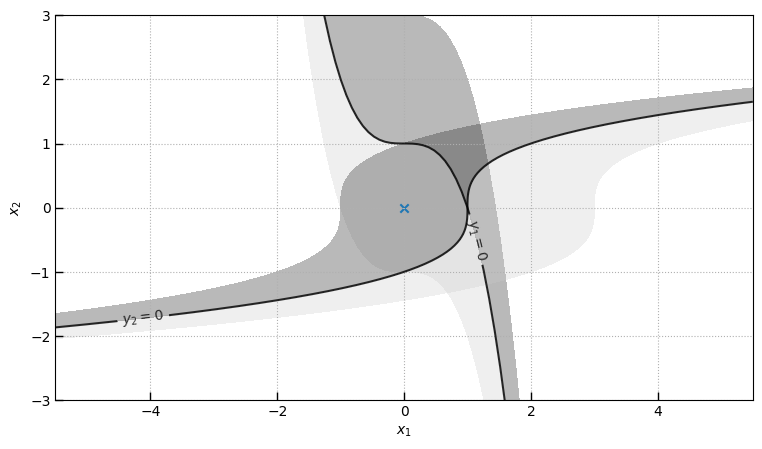

In [6]:
fig, ax = plot_nonlinear_system(func); _ = ax.scatter(*[0,0], marker='x')

$\displaystyle F\left({ x \atop y }\right) = \left( { F_1 \atop F_2 } \right) = \left( { {x^3 + y - 1} \atop { y^3 - x + 1 } } \right) = 0$

$\displaystyle J = \begin{bmatrix} \partial F_1 / \partial x & \partial F_1 / \partial y \\ \partial F_2 / \partial x & \partial F_2 / \partial y \end{bmatrix} = \begin{bmatrix} 3x^2 & 1 \\ -1 & 3y^2 \end{bmatrix} ~~\Rightarrow~~ F^\prime\left({ x \atop y }\right) = \left( { {3 x^2 + 1} \atop { -1 + 3 y^2} } \right)$

In [7]:
# x[0] = x; x[1] = y
def func(x):
    return np.array([x[0]**3 + x[1] - 1, 
                     x[1]**3 - x[0] + 1])
def jac(x):
    return np.array([[3 * x[0]**2, 1        ], 
                     [-1,          3 * x[1]**2]])

In [8]:
def newton_step(xk, func, jac, damp=1, tol=1.e-12):
    sk = np.linalg.solve(jac(xk), -func(xk)) # sk = Delta x_k
    
    if np.linalg.norm(sk, ord=np.inf) < tol:
        return xk, np.full(2, tol)

    xk1 = xk + sk
    return xk1, sk

In [9]:
xk = [0., 0.]
for j in range(10):
    xk, sk = newton_step(xk, func, jac)
    print(f"x_{j+1:<2} = ({xk[0]:8.5f} , {xk[1]:8.5f} )   || sk || = {np.linalg.norm(sk, np.inf):.1e}")

x_1  = ( 1.00000 ,  1.00000 )   || sk || = 1.0e+00
x_2  = ( 0.80000 ,  0.60000 )   || sk || = 4.0e-01
x_3  = ( 0.89599 ,  0.30370 )   || sk || = 3.0e-01
x_4  = ( 0.97140 ,  0.09909 )   || sk || = 2.0e-01
x_5  = ( 0.99827 ,  0.00731 )   || sk || = 9.2e-02
x_6  = ( 1.00000 ,  0.00001 )   || sk || = 7.3e-03
x_7  = ( 1.00000 ,  0.00000 )   || sk || = 1.1e-05
x_8  = ( 1.00000 , -0.00000 )   || sk || = 1.8e-12
x_9  = ( 1.00000 , -0.00000 )   || sk || = 1.0e-12
x_10 = ( 1.00000 , -0.00000 )   || sk || = 1.0e-12


## System of non-linear equations

$\displaystyle F(x) = \left[ { y_1 \atop y_2 } \right] = \left[ { {x_1 + 2x_2 - 2} \atop {x_1^2 + 4x_2^2 -4} } \right] = 0$ $~~;~~$ $\displaystyle J = F^\prime(x) = \left[ { { 1 \;\;\; 2 } \atop {2x_1 ~~ 8x_2 } } \right]$ 

In [10]:
def func(x):
    return np.array([x[0] + 2*x[1] - 2, 
                     x[0]**2 + 4*x[1]**2 - 4])
def jac(x):
    return np.array([[1, 2], 
                     [2*x[0], 8*x[1]]])

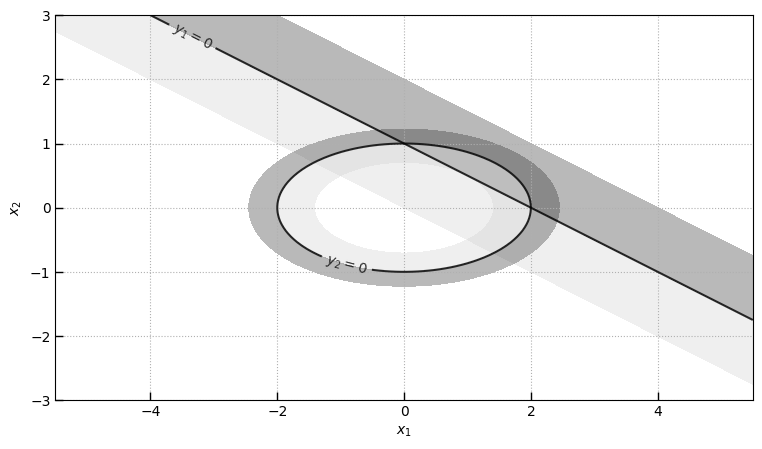

In [11]:
fig, ax = plot_nonlinear_system(func)

In [12]:
def show_newton(func, jac, x0=[1,2], nsteps=10):
    fig, ax = plot_nonlinear_system(func)

    xprev = x0

    ax.text(0.05, 0.1, 'Newton iteration', ha='left', va='bottom', transform=ax.transAxes)

    for i in range(nsteps):
        xk, sk = newton_step(xprev, func, jac)
        if sk is None:
            print(f'Newton stopped after {i} steps: xk = [{xk[0]:.3e} {xk[1]:.3e}]')
            break
            
        ax.plot(*np.array([xprev, xk]).T, color=plt.cm.rainbow(i/nsteps), marker='.',
                alpha=0.5, markersize=15, linewidth=3)
        xprev = xk

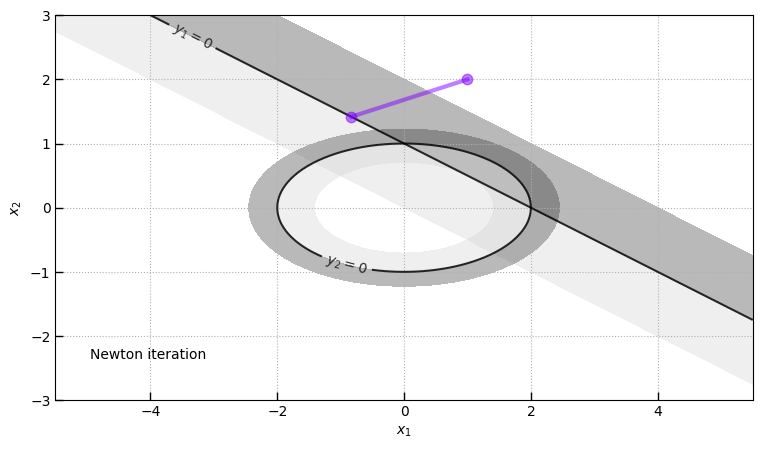

In [13]:
show_newton(func, jac, x0=[1,2], nsteps=1)

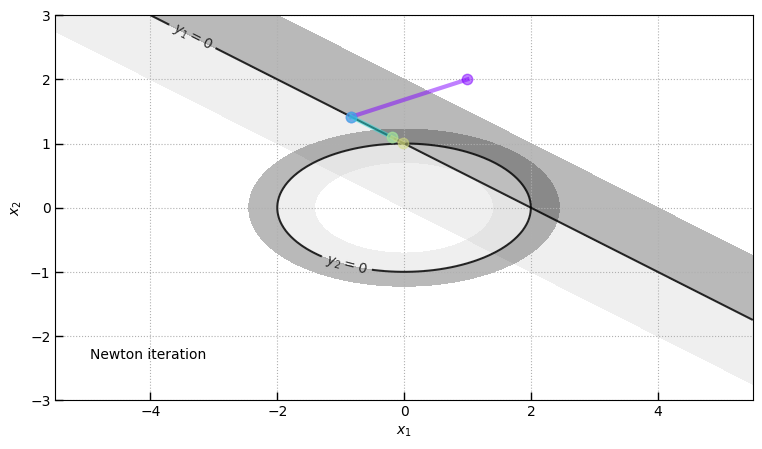

In [14]:
show_newton(func, jac, x0=[1,2], nsteps=3)

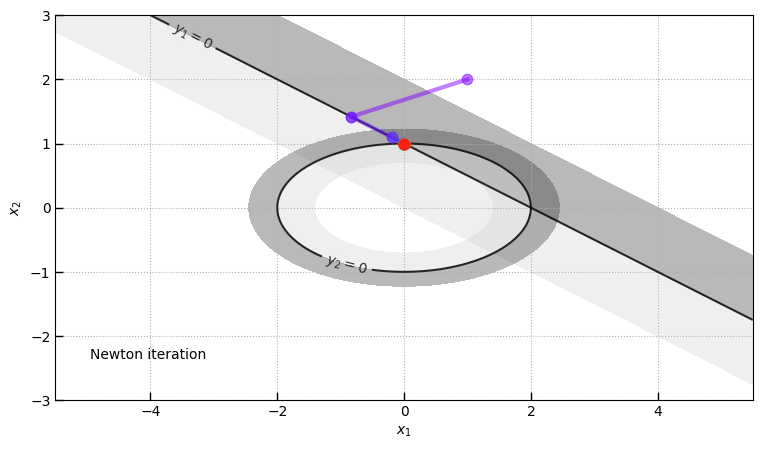

In [15]:
show_newton(func, jac, x0=[1,2], nsteps=30)

# Secant-Updating with the Broyden update

Build updates to Jacobian with simple matrix multiplications:

$B_{k+1} = B_k + (\Delta y_k - B_k \Delta x_k) \Delta x_k^T~/~(\Delta x_k^T \Delta x_k) \approx J_{k+1}$

See, e.g., [P. Klein](https://paulklein.ca/newsite/teaching/broyden.pdf) for a derivation of the update to $B_k$ in the equation above
where $B_{k+1}$

  - satisfies the secant equation $B_{k+1} \Delta x_k = \Delta y_k$
  - and minimizes the Frobenius norm $|| B_{k+1} - B_{k} ||_F$.

The latter constraint can be stated as

> "$B_{k+1}$ changes $B_{k}$ as little as possible and only in the direction of $\Delta x_k$",
    
i.e., choose $B_{k+1}~z = B_k~z$ for every $z$ orthogonal to $\Delta x_k$ ($\Delta x_k^T z = 0$).

In [16]:
def broyden_step(xk, Bk, func, alpha=1, tol=1.e-12):
    
    sk = np.linalg.solve(Bk, -func(xk)) * alpha
    
    if np.linalg.norm(sk, ord=np.inf) < tol:
        return xk, Bk, None

    xk1 = xk + sk
    yk = func(xk1) - func(xk)
    dB = np.outer(yk - Bk@sk, sk) / (sk.T @ sk)

    Bk1 = Bk + dB
    return xk1, Bk1, dB

In [17]:
def show_broyden(func, jac, x0=[1,2], nsteps=30, tol=1.e-12, alpha=1):
    
    fig, ax = plot_nonlinear_system(func)

    Bk = jac(x0)
    xprev = x0

    ax.text(0.05, 0.1, 'Broyden iteration', ha='left', va='bottom', transform=ax.transAxes)
    
    for i in range(nsteps):
        xk, Bk, dB = broyden_step(xprev, Bk, func, tol=tol, alpha=alpha)
        if dB is None:
            print(f'Broyden stopped after {i} steps: xk = [{xk[0]:.3e} {xk[1]:.3e}]')
            break
            
        ax.plot(*np.array([xprev, xk]).T, color=plt.cm.rainbow(i/nsteps),
                marker='.',alpha=0.5, markersize=15, linewidth=3)
        xprev = xk

    return xk, Bk

Broyden stopped after 8 steps: xk = [8.425e-17 1.000e+00]


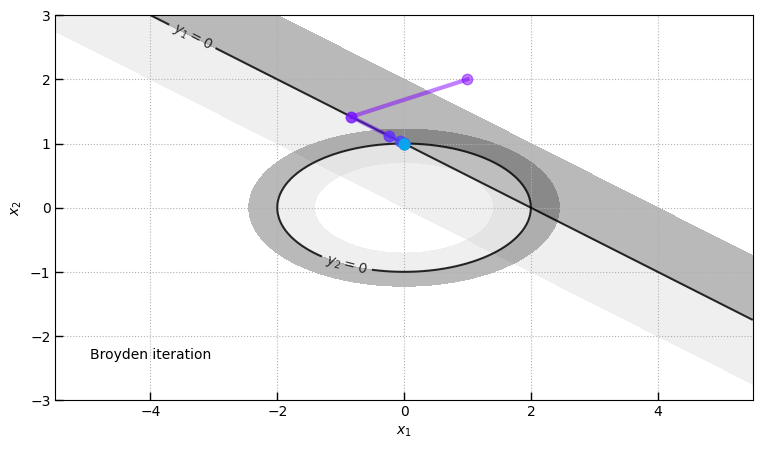

In [18]:
xk, Bk = show_broyden(func, jac, x0=[1,2])

In [19]:
print('B0 = jac(x0):\n', jac([1,2]))
print('jac(xk):\n', jac(xk))
print('Bk:\n', Bk)

B0 = jac(x0):
 [[ 1  2]
 [ 2 16]]
jac(xk):
 [[1.00e+00 2.00e+00]
 [1.68e-16 8.00e+00]]
Bk:
 [[ 1.    2.  ]
 [ 2.83 13.67]]


Broyden stopped after 42 steps: xk = [-1.280e-12 1.000e+00]


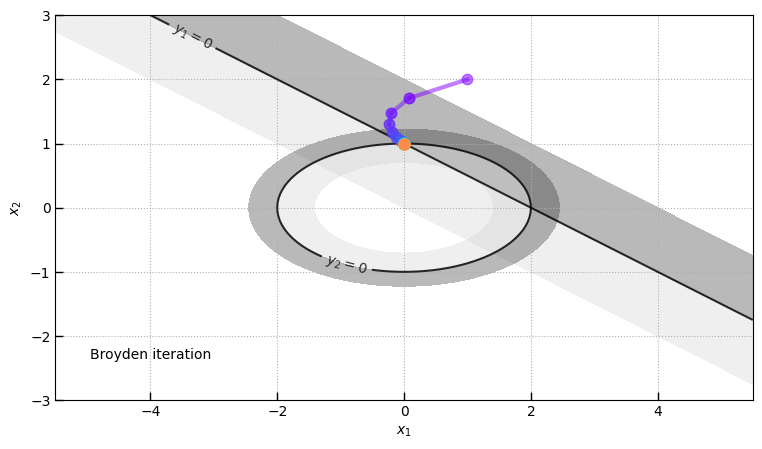

In [20]:
# Damped: scale sk by alpha
xk, Bk = show_broyden(func, jac, x0=[1, 2], alpha=0.5, nsteps=50)

In [21]:
print('B0 = jac(x0):\n', jac([1,2]))
print('jac(xk):\n', jac(xk))
print('Bk:\n', Bk)

B0 = jac(x0):
 [[ 1  2]
 [ 2 16]]
jac(xk):
 [[ 1.00e+00  2.00e+00]
 [-2.56e-12  8.00e+00]]
Bk:
 [[1.   2.  ]
 [0.33 8.43]]


Broyden stopped after 15 steps: xk = [7.181e-15 1.000e+00]


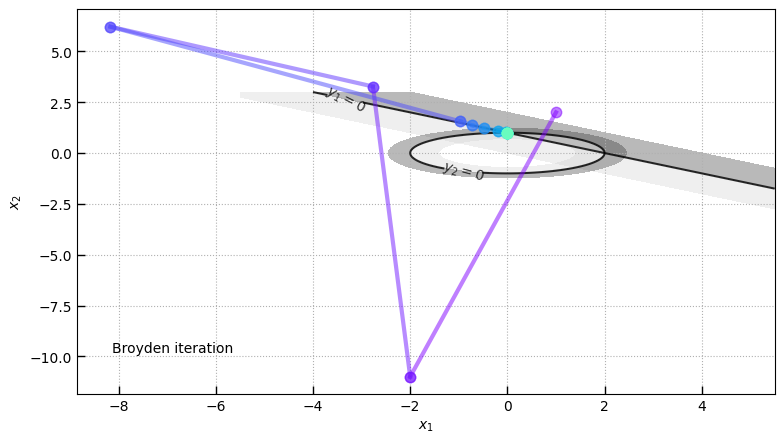

In [22]:
def initialize_jac_with_eye(x_ignored):
    return np.eye(2)

xk, Bk = show_broyden(func, initialize_jac_with_eye, x0=[1, 2])

In [23]:
print('B0 = eye(x0):\n', initialize_jac_with_eye([1,2]))
print('True jac(xk):\n', jac(xk))
print('Bk:\n', Bk)

B0 = eye(x0):
 [[1. 0.]
 [0. 1.]]
True jac(xk):
 [[1.00e+00 2.00e+00]
 [1.44e-14 8.00e+00]]
Bk:
 [[  1.1    2.2 ]
 [-17.49 -27.76]]


Broyden stopped after 62 steps: xk = [-2.243e-12 1.000e+00]


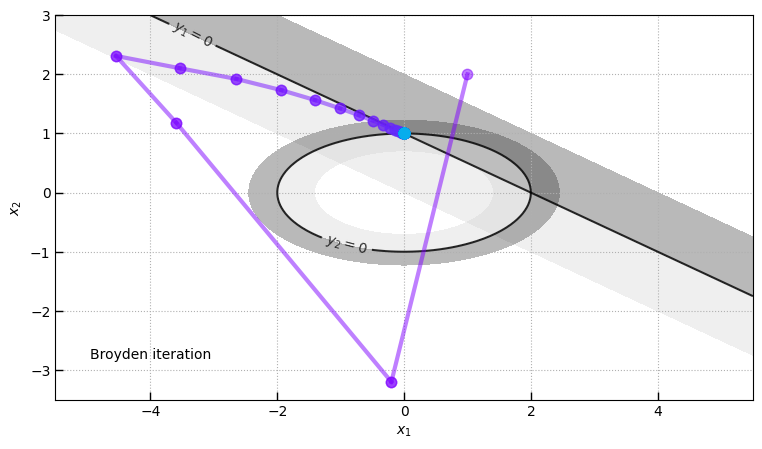

In [24]:
xk, Bk = show_broyden(func, initialize_jac_with_eye, x0=[1, 2], alpha=0.4, nsteps=256)

In [25]:
print('B0 = eye(x0):\n', initialize_jac_with_eye([1,2]))
print('True jac(xk):\n', jac(xk))
print('Bk:\n', Bk)

B0 = eye(x0):
 [[1. 0.]
 [0. 1.]]
True jac(xk):
 [[ 1.00e+00  2.00e+00]
 [-4.49e-12  8.00e+00]]
Bk:
 [[ 1.09  2.2 ]
 [-0.86  6.16]]


Broyden stopped after 8 steps: xk = [2.000e+00 5.423e-17]


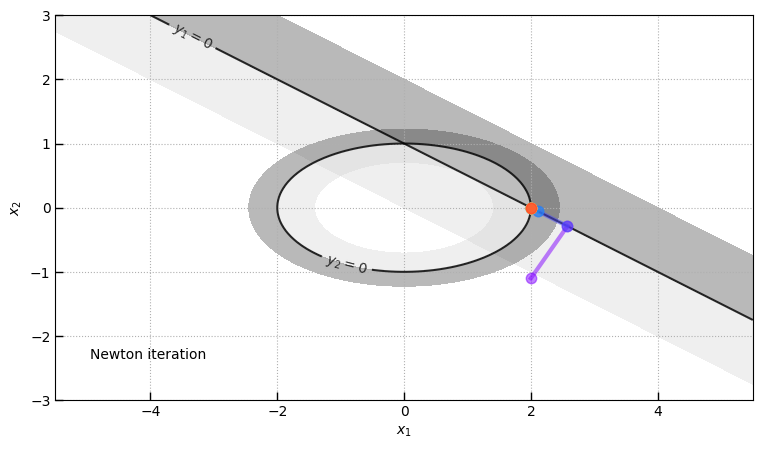

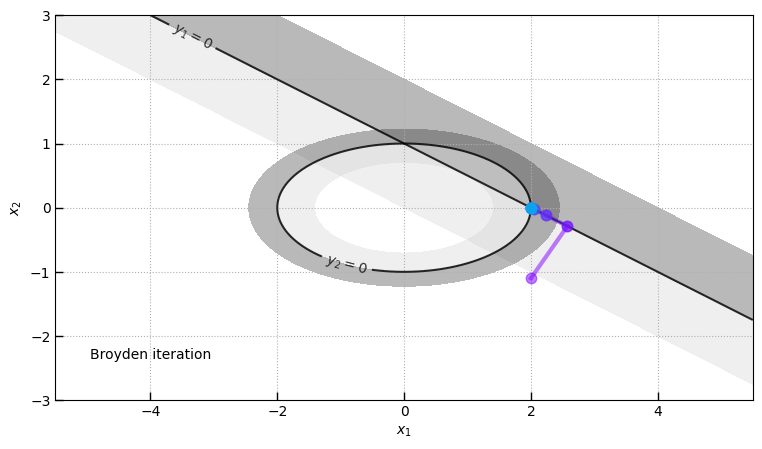

In [26]:
_ = show_newton(func, jac, x0=[2, -1.1])
_ = show_broyden(func, jac, x0=[2, -1.1])

Broyden stopped after 7 steps: xk = [2.000e+00 -7.512e-14]


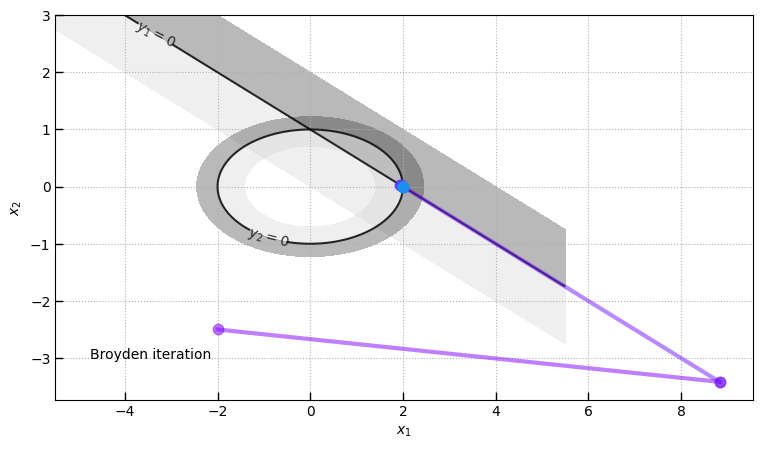

In [27]:
_ = show_broyden(func, jac, x0=[-2, -2.5])

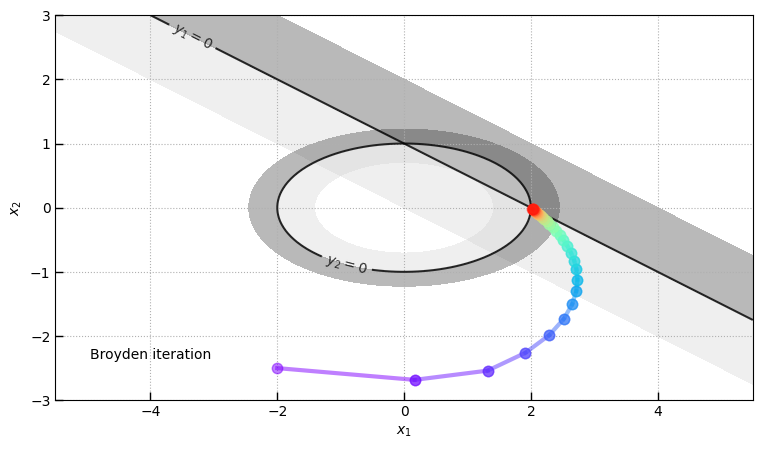

In [28]:
_ = show_broyden(func, jac, x0=[-2, -2.5], alpha=0.2)

# Sherman-Morrison iteration

Like Broyden, but compute updates to the *inverse* of the Jacobian
so that you don't have to solve $B_k \Delta x_k = -f(x_k)$ but rather just need
to do a simple multiplication $\Delta x_k = -B_k^{-1} f(x_k)$.

$B_{k+1}^{-1} = B_k^{-1} + \frac{\Delta x_k~-~B_k^{-1} \Delta y_k}{\Delta x_k^T B_k^{-1} \Delta x_k} \Delta x_k^T B_k^{-1} \approx J_{k+1}^{-1}$

In [29]:
def sherman_morrison_step(xk, Bik, func, tol=1.e-12):
    sk = -Bik.dot(func(xk))

    if np.linalg.norm(sk, ord=np.inf) < tol:
        return xk, Bik, None

    xk1 = xk + sk
    yk = func(xk1) - func(xk)
    dBi = (sk - Bik @ yk) / (sk.T @ Bik @ yk)
    dBi = np.outer(dBi, sk.T @ Bik)
    Bik1 = Bik + dBi
    return xk1, Bik1, dBi

In [30]:
def show_sherman_morrison(func, jac, x0=[1,2], nsteps=30):
    fig, ax = plot_nonlinear_system(func)

    Bk = jac(x0)
    Bik = np.linalg.inv(Bk)
    xprev = x0

    ax.text(0.05, 0.1, 'Sherman-Morrison iteration',
            ha='left', va='bottom', transform=ax.transAxes)
    
    for i in range(nsteps):
        xk, Bik, dBi = sherman_morrison_step(xprev, Bik, func)
        if dBi is None:
            print(f'S-M stopped after {i} steps: xk = [{xk[0]:.3e} {xk[1]:.3e}]')
            break
            
        ax.plot(*np.array([xprev, xk]).T, color=plt.cm.rainbow(i/nsteps),
                marker='.',alpha=0.5, markersize=15, linewidth=3)
        xprev = xk

    return xk, Bik

S-M stopped after 8 steps: xk = [2.028e-16 1.000e+00]


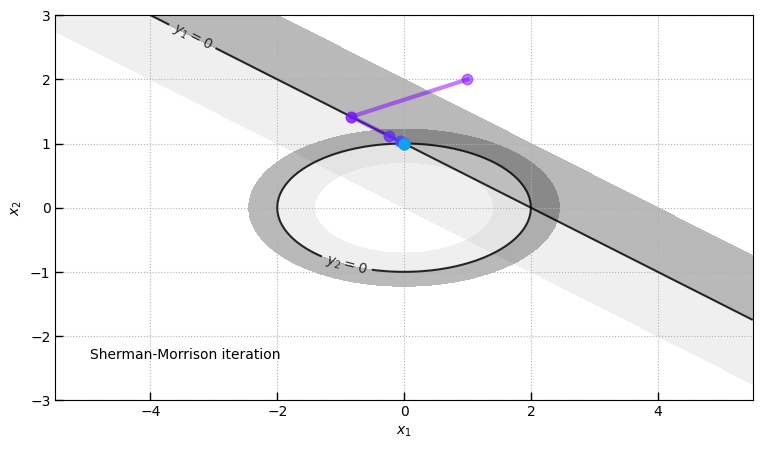

In [31]:
xk, Bik = show_sherman_morrison(func, jac, x0=[1, 2])

In [32]:
print('inv(jac(x0)):\n', np.linalg.inv(jac([1,2])))
print('inv(jac(xk)):\n', np.linalg.inv(jac(xk)))
print('Bik:\n', Bik)

inv(jac(x0)):
 [[ 1.33 -0.17]
 [-0.17  0.08]]
inv(jac(xk)):
 [[ 1.00e+00 -2.50e-01]
 [-5.07e-17  1.25e-01]]
Bik:
 [[ 1.71 -0.25]
 [-0.35  0.12]]


S-M stopped after 15 steps: xk = [5.531e-15 1.000e+00]


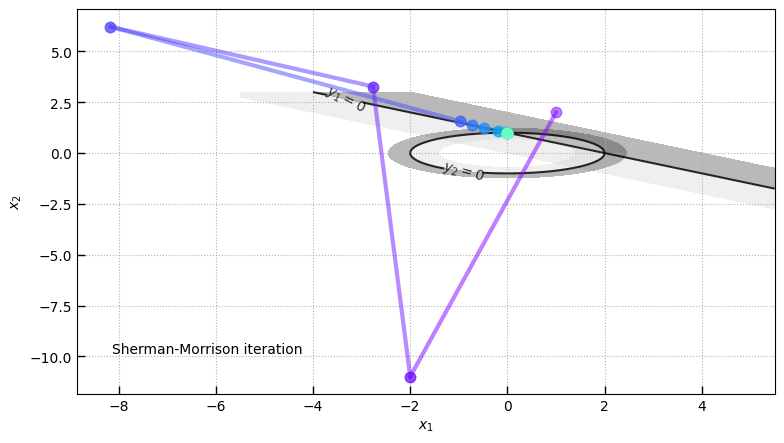

In [33]:
_ = show_sherman_morrison(func, initialize_jac_with_eye, x0=[1, 2])